<a href="https://colab.research.google.com/github/feist000/Project/blob/master/%EA%B3%A0%EC%96%91%EC%8B%9C%20%EA%B3%B5%EA%B3%B5%EC%9E%90%EC%A0%84%EA%B1%B0%20%EC%8A%A4%ED%85%8C%EC%9D%B4%EC%85%98/3_%EA%B3%A0%EC%96%91%EC%8B%9C_%EA%B1%B0%EC%A3%BC_%EC%9D%B8%EA%B5%AC_(%EC%B5%9C%EC%A2%85).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3. 고양시 거주 인구
### 1) 최근 3개년(2017-2019) 고양시 인구 변화
### 2) 신규 택지 개발 지역(장항/송산/대화) 3개년 인구 변화
### 3) 인구 누적 분포

In [ ]:
import pathlib
import random
from functools import reduce
from collections import defaultdict

import pandas as pd
import geopandas as gpd
import folium
import shapely
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xgboost
import sklearn.cluster
import tensorflow as tf

from geoband import API

/opt/app-root/lib/python3.6/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### 공공자전거와 대중교통 데이터 분석 결과
   ##### - 버스/지하철 역별 인구과밀집 지역 데이터로 특정 지역에 인구 과밀집
   ##### - 해당 과밀집 지역에서 점심/퇴근 시간에 공공 자전거 이용률 최다(주로 200번대 정류장)
   ##### - 출근 및 새벽 시간대는 300번대 자전거 정류장 사용
   ##### 주거 밀집지역 인근
   ##### 두 시간 대 이용 정류장 차이를 위해 주거 지역 인구 및 인구 밀도 데이터 분석

In [ ]:
input_path = pathlib.Path('./input')
if not input_path.is_dir():
    input_path.mkdir()
    
API.GetCompasData('SBJ_2007_001', '6', input_path.joinpath('06.인구(거주)분포도(100M_X_100M).geojson'))
API.GetCompasData('SBJ_2007_001', '7', input_path.joinpath('07.인구통계.csv'))
API.GetCompasData('SBJ_2007_001', '8', input_path.joinpath('08.행정경계(시군구).geojson'))
API.GetCompasData('SBJ_2007_001', '34', input_path.joinpath('34.고양시_행정경계(행정동기준).geojson'))

for path in list(input_path.glob('*.csv')) + list(input_path.glob('*.geojson')):
    print(path)

input/01.운영이력.csv
input/02.자전거스테이션.csv
input/19.전철역_공간정보.csv
input/20.고양시 버스정류소.csv
input/07.인구통계.csv
input/운영이력.csv
input/자전거스테이션.csv
input/전철역_공간정보.csv
input/고양시 버스정류소.csv
input/17.일반건물 분포도(100M X 100M).geojson
input/15.도로명주소_건물.geojson
input/16.도로명주소_도로.geojson
input/06.인구(거주)분포도(100M_X_100M).geojson
input/일반건물 분포도(100M X 100M).geojson
input/도로명주소_건물.geojson
input/도로명주소_도로.geojson
input/34.고양시_행정경계(행정동기준).geojson
input/08.행정경계(시군구).geojson


# 1. 고양시 인구 변화

### 인구통계 변수
- 행정구역: 행정 구역 구분
- 조회기준: 조사한 연/월
- 총인구수: 총 인구 수
- 세대수: 세대 수
- 세대당 인구: 세대당 평균 인구
- 남자 인구수: 남자 총 인구 수
- 여자 인구수: 여자 총 인구 수
- 남여 비율: 남여 비율

In [ ]:
# 고양시 전체 인구 통계 데이터 확인
population = pd.read_csv('07.인구통계.csv') ; population

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
0,경기도 고양시 (4128000000),2017년01월,"1,040,648","402,440",2.59,"511,353","529,295",0.97
1,경기도 고양시 (4128000000),2017년02월,"1,040,483","403,042",2.58,"511,266","529,217",0.97
2,경기도 고양시 (4128000000),2017년03월,"1,040,482","403,443",2.58,"511,182","529,300",0.97
3,경기도 고양시 (4128000000),2017년04월,"1,040,608","403,933",2.58,"511,225","529,383",0.97
4,경기도 고양시 (4128000000),2017년05월,"1,040,892","404,603",2.57,"511,347","529,545",0.97
...,...,...,...,...,...,...,...,...
1579,경기도 고양시 일산서구 송산동(4128759000),2019년08월,"50,610","18,390",2.75,"24,983","25,627",0.97
1580,경기도 고양시 일산서구 송산동(4128759000),2019년09월,"50,694","18,404",2.75,"25,025","25,669",0.97
1581,경기도 고양시 일산서구 송산동(4128759000),2019년10월,"50,660","18,398",2.75,"25,020","25,640",0.98
1582,경기도 고양시 일산서구 송산동(4128759000),2019년11월,"50,865","18,480",2.75,"25,112","25,753",0.98


In [ ]:
# 고양시 전체 총 인구 변화 추이

population_all = population.loc[population['행정구역'].str.contains('4128000000', na=False)]
population_all

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
0,경기도 고양시 (4128000000),2017년01월,"1,040,648","402,440",2.59,"511,353","529,295",0.97
1,경기도 고양시 (4128000000),2017년02월,"1,040,483","403,042",2.58,"511,266","529,217",0.97
2,경기도 고양시 (4128000000),2017년03월,"1,040,482","403,443",2.58,"511,182","529,300",0.97
3,경기도 고양시 (4128000000),2017년04월,"1,040,608","403,933",2.58,"511,225","529,383",0.97
4,경기도 고양시 (4128000000),2017년05월,"1,040,892","404,603",2.57,"511,347","529,545",0.97
5,경기도 고양시 (4128000000),2017년06월,"1,041,375","405,641",2.57,"511,587","529,788",0.97
6,경기도 고양시 (4128000000),2017년07월,"1,041,587","406,314",2.56,"511,575","530,012",0.97
7,경기도 고양시 (4128000000),2017년08월,"1,041,507","406,768",2.56,"511,486","530,021",0.97
8,경기도 고양시 (4128000000),2017년09월,"1,041,399","407,272",2.56,"511,328","530,071",0.96
9,경기도 고양시 (4128000000),2017년10월,"1,041,706","407,871",2.55,"511,397","530,309",0.96


In [ ]:
# 인구 추이 변화를 보기 위해 시각화
# '총인구수'가 object이기에 float로 변환
# 빠른 계산을 위해 ','제거

population['총인구수']=population['총인구수'].str.replace(',','').astype(float)

/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='조회기준'>

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current

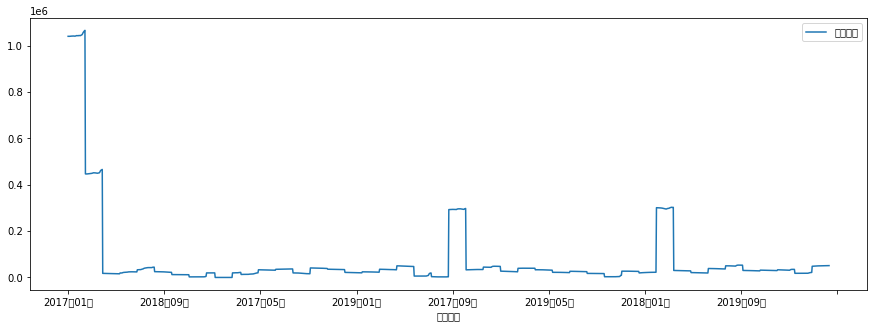

In [ ]:
population.plot(x='조회기준', y='총인구수', kind='line', figsize=(15,5))

# 2. 신규 택지 개발 지역(장항1동/송산동/대화동) 3개년 인구 변화

In [ ]:
# 송산동
population_song=population.loc[population['행정구역'].str.contains('송산', na=False)]
#na 파라미터의 역할 : 결측치 채우기

population_song

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
1548,경기도 고양시 일산서구 송산동(4128759000),2017년01월,48294.0,"16,855",2.87,"23,893","24,401",0.98
1549,경기도 고양시 일산서구 송산동(4128759000),2017년02월,48456.0,"16,938",2.86,"23,995","24,461",0.98
1550,경기도 고양시 일산서구 송산동(4128759000),2017년03월,48619.0,"17,002",2.86,"24,060","24,559",0.98
1551,경기도 고양시 일산서구 송산동(4128759000),2017년04월,48837.0,"17,080",2.86,"24,158","24,679",0.98
1552,경기도 고양시 일산서구 송산동(4128759000),2017년05월,48955.0,"17,146",2.86,"24,216","24,739",0.98
1553,경기도 고양시 일산서구 송산동(4128759000),2017년06월,49045.0,"17,198",2.85,"24,273","24,772",0.98
1554,경기도 고양시 일산서구 송산동(4128759000),2017년07월,49085.0,"17,216",2.85,"24,270","24,815",0.98
1555,경기도 고양시 일산서구 송산동(4128759000),2017년08월,49104.0,"17,221",2.85,"24,282","24,822",0.98
1556,경기도 고양시 일산서구 송산동(4128759000),2017년09월,49307.0,"17,310",2.85,"24,376","24,931",0.98
1557,경기도 고양시 일산서구 송산동(4128759000),2017년10월,49473.0,"17,407",2.84,"24,437","25,036",0.98


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='조회기준'>

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current

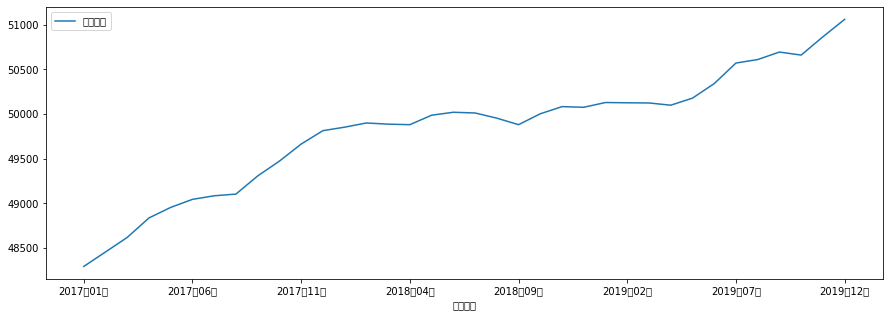

In [ ]:
# 송산동 인구 추이 변화를 보기 위해 시각화
# '총인구수'가 object이기에 int로 변환


population_song['총인구수']=population_song['총인구수'].astype(int)

# 송산 인구변화 추이
population_song.plot(x='조회기준', y='총인구수', kind='line', figsize=(15,5))

In [ ]:
# 대화동
population_dae=population.loc[population['행정구역'].str.contains('대화', na=False)]
population_dae

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
1476,경기도 고양시 일산서구 대화동(4128757000),2017년01월,33108.0,"13,781",2.40,"16,042","17,066",0.94
1477,경기도 고양시 일산서구 대화동(4128757000),2017년02월,33053.0,"13,767",2.40,"16,004","17,049",0.94
1478,경기도 고양시 일산서구 대화동(4128757000),2017년03월,33047.0,"13,790",2.40,"15,984","17,063",0.94
1479,경기도 고양시 일산서구 대화동(4128757000),2017년04월,32940.0,"13,745",2.40,"15,949","16,991",0.94
1480,경기도 고양시 일산서구 대화동(4128757000),2017년05월,32870.0,"13,742",2.39,"15,907","16,963",0.94
1481,경기도 고양시 일산서구 대화동(4128757000),2017년06월,32827.0,"13,800",2.38,"15,878","16,949",0.94
1482,경기도 고양시 일산서구 대화동(4128757000),2017년07월,32836.0,"13,829",2.37,"15,842","16,994",0.93
1483,경기도 고양시 일산서구 대화동(4128757000),2017년08월,32763.0,"13,807",2.37,"15,793","16,970",0.93
1484,경기도 고양시 일산서구 대화동(4128757000),2017년09월,32697.0,"13,793",2.37,"15,755","16,942",0.93
1485,경기도 고양시 일산서구 대화동(4128757000),2017년10월,32615.0,"13,793",2.36,"15,733","16,882",0.93


/opt/app-root/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='조회기준'>

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current

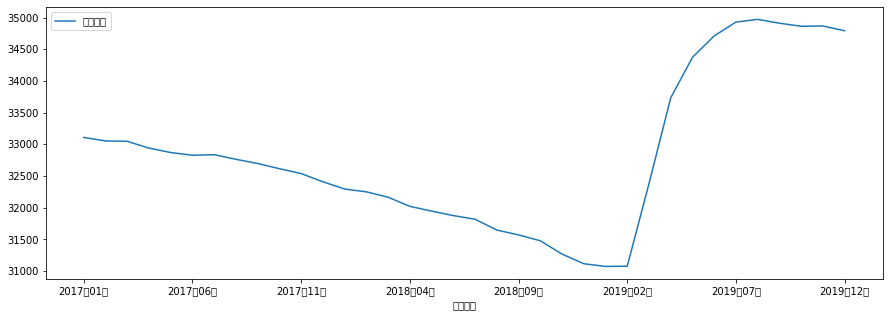

In [ ]:
# 데이터 타입 변경
population_dae['총인구수'] = population_dae['총인구수'].astype(int)
population_dae['총인구수'].head()

# 대화 인구변화 추이
population_dae.plot(x='조회기준', y='총인구수', kind='line', figsize=(15,5))

In [ ]:
# 장항동
population_jang1 = population.loc[population['행정구역'].str.contains('장항1', na=False)]
population_jang1

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
1116,경기도 고양시 일산동구 장항1동(4128558000),2017년01월,"3,077","1,611",1.91,"1,723","1,354",1.27
1117,경기도 고양시 일산동구 장항1동(4128558000),2017년02월,"3,067","1,610",1.90,"1,719","1,348",1.28
1118,경기도 고양시 일산동구 장항1동(4128558000),2017년03월,"3,084","1,620",1.90,"1,734","1,350",1.28
1119,경기도 고양시 일산동구 장항1동(4128558000),2017년04월,"3,078","1,616",1.90,"1,729","1,349",1.28
1120,경기도 고양시 일산동구 장항1동(4128558000),2017년05월,"3,093","1,622",1.91,"1,739","1,354",1.28
1121,경기도 고양시 일산동구 장항1동(4128558000),2017년06월,"3,099","1,633",1.90,"1,750","1,349",1.30
1122,경기도 고양시 일산동구 장항1동(4128558000),2017년07월,"3,096","1,635",1.89,"1,749","1,347",1.30
1123,경기도 고양시 일산동구 장항1동(4128558000),2017년08월,"3,079","1,634",1.88,"1,746","1,333",1.31
1124,경기도 고양시 일산동구 장항1동(4128558000),2017년09월,"3,093","1,639",1.89,"1,748","1,345",1.30
1125,경기도 고양시 일산동구 장항1동(4128558000),2017년10월,"3,108","1,643",1.89,"1,754","1,354",1.30


In [ ]:
population_jang1_2 = population_jang1.copy()
population_jang1_2['총인구수']=population_jang1_2['총인구수'].str.replace(',', '').astype(float)

/opt/app-root/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='조회기준'>

/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 45380 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51312 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 54924 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/app-root/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 51456 missing from current

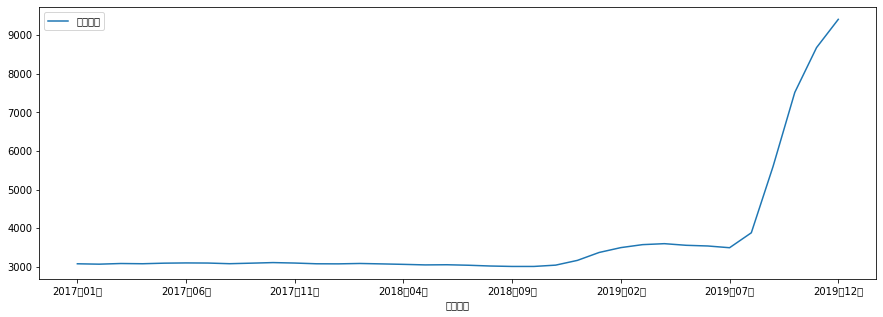

In [ ]:
population_jang1_2.plot(x='조회기준', y='총인구수', kind='line', figsize=(15,5))


## 인구 통계 분석 결과

1. 송산동은 2017년 1월 이후 꾸준한 인구 증가
2. 대화동은 인구 감소세에서 2019년 2월 기준 급격한 증가
3. 장항동은 2019년 들어 인구 유입 증가

### 분석결과를 통한 현재 결론
   1. 현재 자전거 스테이션은 유동인구가 많은 버스/지하철 정류장 인근 
        -> 현황 유지
   2. 막차 이후 사용량이 많지만 반납 장소가 거주지에서 멀리 떨어져 있어 반납의 어려움이 있음. 
        -> 막차 이후 대여량이 많아지는 정류장+ 반납량이 많은 스테이션 주변에 추가 설치
   3. 장항/송산/대화 지역 거주 인구 증가에 비례하지 못하는 자전거 스테이션 
        -> 장항/송산/대화 인구에 맞는 자전거 스테이션 위치 추가 확보
        
### 인구누적분포데이터 분석
- 장항/송산/대화 지역 인구 밀집 현황 확인
- 특히 킨텍스 신시가지 및 호수공원 일대 인구 변화 확인


In [ ]:
# 인구누적분포 데이터
# geopandas
pop_distribution = gpd.read_file('06.인구(거주)분포도(100M_X_100M).geojson')
pop_distribution

,gid,val,geometry
0,다사268650,NaN,"MULTIPOLYGON (((126.66985 37.68162, 126.66984 ..."
1,다사268651,NaN,"MULTIPOLYGON (((126.66984 37.68252, 126.66983 ..."
2,다사268652,NaN,"MULTIPOLYGON (((126.66983 37.68342, 126.66982 ..."
3,다사268653,NaN,"MULTIPOLYGON (((126.66982 37.68432, 126.66981 ..."
4,다사268654,NaN,"MULTIPOLYGON (((126.66981 37.68522, 126.66980 ..."
...,...,...,...
27345,다사553641,NaN,"MULTIPOLYGON (((126.99310 37.67534, 126.99310 ..."
27346,다사553642,NaN,"MULTIPOLYGON (((126.99310 37.67624, 126.99309 ..."
27347,다사553643,NaN,"MULTIPOLYGON (((126.99309 37.67714, 126.99308 ..."
27348,다사553644,NaN,"MULTIPOLYGON (((126.99308 37.67804, 126.99308 ..."


In [ ]:
# val컬럼의 NaN : 거주인구 없음을 의미
# val컬럼의 NaN값을 제외한 시리즈 추출
pop_distribution_val=pop_distribution.groupby(['gid','val']).sum()

pop_distribution_val=pop_distribution_val.reset_index()
pop_distribution_val

,gid,val
0,다사277649,0.0
1,다사277652,8.0
2,다사277653,11.0
3,다사277656,0.0
4,다사278651,13.0
...,...,...
9236,다사536607,0.0
9237,다사538597,0.0
9238,다사538608,0.0
9239,다사539608,0.0


In [ ]:
from shapely.geometry import Point
import plotly_express as px

In [ ]:
# 고양시 전체  인구통계 중 가장 최근 것만 가져온다.
population_latest = population.loc[population['조회기준'].str.contains('2019년12월', na=False)]
population_latest

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
35,경기도 고양시 (4128000000),2019년12월,"1,066,351","434,028",2.46,"522,749","543,602",0.96
71,경기도 고양시 덕양구 (4128100000),2019년12월,"466,157","195,766",2.38,"230,858","235,299",0.98
107,경기도 고양시 덕양구 주교동(4128151000),2019년12월,"15,748","7,362",2.14,"8,126","7,622",1.07
143,경기도 고양시 덕양구 원신동(4128152000),2019년12월,"23,942","9,419",2.54,"11,568","12,374",0.93
179,경기도 고양시 덕양구 흥도동(4128153000),2019년12월,"44,565","18,311",2.43,"21,702","22,863",0.95
215,경기도 고양시 덕양구 성사1동(4128154000),2019년12월,"22,062","9,676",2.28,"10,928","11,134",0.98
251,경기도 고양시 덕양구 성사2동(4128155000),2019년12월,"11,729","4,783",2.45,"5,689","6,040",0.94
287,경기도 고양시 덕양구 효자동(4128156000),2019년12월,"5,041","2,480",2.03,"2,546","2,495",1.02
323,경기도 고양시 덕양구 신도동(4128157000),2019년12월,0,0,0.00,0,0,0.00
359,경기도 고양시 덕양구 삼송동(4128157500),2019년12월,"21,879","9,660",2.26,"10,647","11,232",0.95


In [ ]:
# 고양시 전체인구와 구별 인구를 날려준다

population_latest2 = population_latest.copy()
population_latest2.drop([35,71,827,1259], inplace=True)

In [ ]:
population_latest2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 107 to 1583
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   행정구역    40 non-null     object 
 1   조회기준    40 non-null     object 
 2   총인구수    40 non-null     object 
 3   세대수     40 non-null     object 
 4   세대당 인구  40 non-null     float64
 5   남자 인구수  40 non-null     object 
 6   여자 인구수  40 non-null     object 
 7   남여 비율   40 non-null     float64
dtypes: float64(2), object(6)
memory usage: 2.8+ KB


In [ ]:
# 신도동 = 삼송동 (2018년에 개칭했다고 함) => 날려줘야함
# https://namu.wiki/w/%EC%82%BC%EC%86%A1%EB%8F%99

population_latest3 = population_latest2.copy()
population_latest3.drop(323, inplace=True)

In [ ]:
population_latest3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 107 to 1583
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   행정구역    39 non-null     object 
 1   조회기준    39 non-null     object 
 2   총인구수    39 non-null     object 
 3   세대수     39 non-null     object 
 4   세대당 인구  39 non-null     float64
 5   남자 인구수  39 non-null     object 
 6   여자 인구수  39 non-null     object 
 7   남여 비율   39 non-null     float64
dtypes: float64(2), object(6)
memory usage: 2.7+ KB


## 행정동 경계 파일

In [ ]:
# 행정동 경계
hang = gpd.read_file(input_path.joinpath('34.고양시_행정경계(행정동기준).geojson'))
hang

,행정동코드,행정동명,geometry
0,3110151,주교동,"MULTIPOLYGON (((126.83514 37.67683, 126.83517 ..."
1,3110152,원신동,"MULTIPOLYGON (((126.84983 37.68986, 126.84996 ..."
2,3110153,흥도동,"MULTIPOLYGON (((126.87615 37.64768, 126.87562 ..."
3,3110154,성사1동,"MULTIPOLYGON (((126.84898 37.66872, 126.84915 ..."
4,3110155,성사2동,"MULTIPOLYGON (((126.83502 37.65491, 126.83527 ..."
5,3110156,효자동,"MULTIPOLYGON (((126.95736 37.69195, 126.95790 ..."
6,3110170,삼송동,"MULTIPOLYGON (((126.90630 37.67545, 126.90630 ..."
7,3110158,창릉동,"MULTIPOLYGON (((126.90072 37.65079, 126.90124 ..."
8,3110159,고양동,"MULTIPOLYGON (((126.92910 37.74849, 126.92964 ..."
9,3110160,관산동,"MULTIPOLYGON (((126.85891 37.73417, 126.85881 ..."


In [ ]:
hang.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   행정동코드     39 non-null     object  
 1   행정동명      39 non-null     object  
 2   geometry  39 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 1.0+ KB


## population_latest(2019년 12월 인구통계)에 경위도값 더해주기

In [ ]:
# 인구통계의 '행정구역'과 행정동의 '행정동명'이 일치해야한다
# https://www.geeksforgeeks.org/python-pandas-series-str-extract/

population_latest4 = population_latest3.copy()
population_latest4['행정구역'] = population_latest4['행정구역'].str[12:].str[-16:-12].str.replace(' ','')
population_latest4

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
107,주교동,2019년12월,"15,748","7,362",2.14,"8,126","7,622",1.07
143,원신동,2019년12월,"23,942","9,419",2.54,"11,568","12,374",0.93
179,흥도동,2019년12월,"44,565","18,311",2.43,"21,702","22,863",0.95
215,성사1동,2019년12월,"22,062","9,676",2.28,"10,928","11,134",0.98
251,성사2동,2019년12월,"11,729","4,783",2.45,"5,689","6,040",0.94
287,효자동,2019년12월,"5,041","2,480",2.03,"2,546","2,495",1.02
359,삼송동,2019년12월,"21,879","9,660",2.26,"10,647","11,232",0.95
395,창릉동,2019년12월,"19,852","8,515",2.33,"9,970","9,882",1.01
431,고양동,2019년12월,"31,168","12,763",2.44,"15,651","15,517",1.01
467,관산동,2019년12월,"36,611","16,182",2.26,"18,644","17,967",1.04


In [ ]:
# 경위도값 입력

import warnings
warnings.filterwarnings(action='ignore') # 경고메시지가 떠서 설치해줌

population_latest4['geometry'] = 0

for i in range(len(population_latest4['행정구역'])):
    for j in range(len(hang['행정동명'])):
        if population_latest4['행정구역'].iloc[i] == hang['행정동명'].iloc[j] :
            population_latest4['geometry'].iloc[i] = hang['geometry'].iloc[j]
            break

In [ ]:
population_latest4

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,geometry
107,주교동,2019년12월,"15,748","7,362",2.14,"8,126","7,622",1.07,(POLYGON ((126.8351382691004 37.67683481916347...
143,원신동,2019년12월,"23,942","9,419",2.54,"11,568","12,374",0.93,(POLYGON ((126.8498343812966 37.68985923284904...
179,흥도동,2019년12월,"44,565","18,311",2.43,"21,702","22,863",0.95,(POLYGON ((126.8761498094425 37.64767924861452...
215,성사1동,2019년12월,"22,062","9,676",2.28,"10,928","11,134",0.98,(POLYGON ((126.8489798158804 37.66872091518727...
251,성사2동,2019년12월,"11,729","4,783",2.45,"5,689","6,040",0.94,"(POLYGON ((126.8350241399075 37.6549071786553,..."
287,효자동,2019년12월,"5,041","2,480",2.03,"2,546","2,495",1.02,(POLYGON ((126.9573625714565 37.69194768044995...
359,삼송동,2019년12월,"21,879","9,660",2.26,"10,647","11,232",0.95,(POLYGON ((126.9063025510095 37.67545134414731...
395,창릉동,2019년12월,"19,852","8,515",2.33,"9,970","9,882",1.01,(POLYGON ((126.9007203787597 37.65079259143342...
431,고양동,2019년12월,"31,168","12,763",2.44,"15,651","15,517",1.01,(POLYGON ((126.9290958517618 37.74848500799976...
467,관산동,2019년12월,"36,611","16,182",2.26,"18,644","17,967",1.04,(POLYGON ((126.8589108100696 37.73417369660056...


In [ ]:
# QGIS에서 value값에 따라 시각화를 해보려면 데이터타입이 숫자형이어야 한다

population_latest4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39 entries, 107 to 1583
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   행정구역      39 non-null     object 
 1   조회기준      39 non-null     object 
 2   총인구수      39 non-null     object 
 3   세대수       39 non-null     object 
 4   세대당 인구    39 non-null     float64
 5   남자 인구수    39 non-null     object 
 6   여자 인구수    39 non-null     object 
 7   남여 비율     39 non-null     float64
 8   geometry  39 non-null     object 
dtypes: float64(2), object(7)
memory usage: 3.0+ KB


In [ ]:
# 총인구수, 세대수, 남자 인구수, 여자 인구수를 숫자형으로 변환
population_latest5 = population_latest4.copy()

population_latest5["총인구수"]= population_latest5["총인구수"].str.replace(',','')
population_latest5["세대수"]= population_latest5["세대수"].str.replace(',','')
population_latest5["남자 인구수"]= population_latest5["남자 인구수"].str.replace(',','')
population_latest5["여자 인구수"]= population_latest5["여자 인구수"].str.replace(',','')


population_latest5["총인구수"]= population_latest5["총인구수"].astype(int)
population_latest5["세대수"]= population_latest5["세대수"].astype(int)
population_latest5["남자 인구수"]= population_latest5["남자 인구수"].astype(int)
population_latest5["여자 인구수"]= population_latest5["여자 인구수"].astype(int)

In [ ]:
population_latest5.head(3)

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율,geometry
107,주교동,2019년12월,15748,7362,2.14,8126,7622,1.07,(POLYGON ((126.8351382691004 37.67683481916347...
143,원신동,2019년12월,23942,9419,2.54,11568,12374,0.93,(POLYGON ((126.8498343812966 37.68985923284904...
179,흥도동,2019년12월,44565,18311,2.43,21702,22863,0.95,(POLYGON ((126.8761498094425 37.64767924861452...


In [ ]:
# 이 파일을 csv로 저장

population_latest5.to_csv('population_latest5.csv')

### 인구통계 데이터를 구별로 매핑

In [ ]:
population_latest2 = population.loc[population['조회기준'].str.contains('2019년12월', na=False)]
population_latest2

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
35,경기도 고양시 (4128000000),2019년12월,"1,066,351","434,028",2.46,"522,749","543,602",0.96
71,경기도 고양시 덕양구 (4128100000),2019년12월,"466,157","195,766",2.38,"230,858","235,299",0.98
107,경기도 고양시 덕양구 주교동(4128151000),2019년12월,"15,748","7,362",2.14,"8,126","7,622",1.07
143,경기도 고양시 덕양구 원신동(4128152000),2019년12월,"23,942","9,419",2.54,"11,568","12,374",0.93
179,경기도 고양시 덕양구 흥도동(4128153000),2019년12월,"44,565","18,311",2.43,"21,702","22,863",0.95
215,경기도 고양시 덕양구 성사1동(4128154000),2019년12월,"22,062","9,676",2.28,"10,928","11,134",0.98
251,경기도 고양시 덕양구 성사2동(4128155000),2019년12월,"11,729","4,783",2.45,"5,689","6,040",0.94
287,경기도 고양시 덕양구 효자동(4128156000),2019년12월,"5,041","2,480",2.03,"2,546","2,495",1.02
323,경기도 고양시 덕양구 신도동(4128157000),2019년12월,0,0,0.00,0,0,0.00
359,경기도 고양시 덕양구 삼송동(4128157500),2019년12월,"21,879","9,660",2.26,"10,647","11,232",0.95


In [ ]:
population_latest2_gu = population_latest2.loc[[71,827,1259], :]
population_latest2_gu

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
71,경기도 고양시 덕양구 (4128100000),2019년12월,"466,157","195,766",2.38,"230,858","235,299",0.98
827,경기도 고양시 일산동구 (4128500000),2019년12월,"297,671","122,981",2.42,"144,991","152,680",0.95
1259,경기도 고양시 일산서구 (4128700000),2019년12월,"302,523","115,281",2.62,"146,900","155,623",0.94


In [ ]:
# 행정구역 이름을 맞춰준다

population_latest2_gu2 = population_latest2_gu.copy()

population_latest2_gu2['행정구역'] = population_latest2_gu2['행정구역'].str.replace(' ','').str[3:].str[-19:-12]
population_latest2_gu2

,행정구역,조회기준,총인구수,세대수,세대당 인구,남자 인구수,여자 인구수,남여 비율
71,고양시덕양구,2019년12월,"466,157","195,766",2.38,"230,858","235,299",0.98
827,고양시일산동구,2019년12월,"297,671","122,981",2.42,"144,991","152,680",0.95
1259,고양시일산서구,2019년12월,"302,523","115,281",2.62,"146,900","155,623",0.94


In [ ]:
# 시군구 데이터 열기

sgg = gpd.read_file('08.행정경계(시군구).geojson')
sgg.head(3) 

,SIG_CD,SIG_KOR_NM,geometry
0,41281,고양시덕양구,"MULTIPOLYGON (((126.92910 37.74849, 126.92964 ..."
1,41285,고양시일산동구,"MULTIPOLYGON (((126.77762 37.67899, 126.77825 ..."
2,41287,고양시일산서구,"MULTIPOLYGON (((126.76703 37.70717, 126.76719 ..."


In [ ]:
# 시군구별로 위경도 묶어주기
population_latest2_gu2['geometry'] = 0

for i in range(len(population_latest2_gu['행정구역'])):
    for j in range(len(sgg['SIG_KOR_NM'])):
        if population_latest2_gu2['행정구역'].iloc[i] == sgg['SIG_KOR_NM'].iloc[j] :
            population_latest2_gu2['geometry'].iloc[i] = sgg['geometry'].iloc[j]
            break

In [ ]:
# csv로 저장

population_latest2_gu2.to_csv('population_latest_gu2.csv')